In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import os
import re
import glob
import scipy as sp
import matplotlib
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.pyplot as plt

In [2]:
# data downloaded from GEO https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116256 and extracted
samples = pd.read_csv('../data/van_Galen/sample_names.txt', header = None)[0].values
#sample_names.txt was generated by running ls *.dem.txt.gz | grep -o '[^_]*$' | awk -F\. '{print $1}' > sample_names.txt

In [3]:
# read in data downloaded from GEO - GSE116256
adatas = []
for i in range(0, len(samples)):
    d_fpattern = r'../data/van_Galen/{}_{}.dem.txt.gz'
    d_file = glob.glob(d_fpattern.format('*', samples[i]))
    data = pd.read_csv(d_file[0], sep = '\t', index_col = 0)
    a_fpattern = r'../data/van_Galen/{}_{}.anno.txt.gz'
    a_file = glob.glob(a_fpattern.format('*', samples[i]))
    meta = pd.read_csv(a_file[0], sep = '\t', index_col = 0)
    adata = sc.AnnData(X = data.T, obs = meta)
    adatas.append(adata)            

In [4]:
adata_all = adatas[0].concatenate(adatas[1:], batch_key='sample_ID', index_unique=None)
adata_all

/home/sennis/anaconda3/lib/python3.7/site-packages/anndata/_core/merge.py:461: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  obs = pd.concat([a.obs for a in adatas], ignore_index=True)


AnnData object with n_obs × n_vars = 41090 × 27899
    obs: 'AlignedToGenome', 'AlignedToTranscriptome', 'CellType', 'CyclingBinary', 'CyclingScore', 'MutTranscripts', 'NanoporeTranscripts', 'NumberOfGenes', 'NumberOfReads', 'PredictionRF2', 'PredictionRefined', 'Score_B', 'Score_CTL', 'Score_GMP', 'Score_HSC', 'Score_Mono', 'Score_NK', 'Score_Plasma', 'Score_ProB', 'Score_ProMono', 'Score_Prog', 'Score_T', 'Score_cDC', 'Score_earlyEry', 'Score_lateEry', 'Score_pDC', 'TranscriptomeUMIs', 'WtTranscripts', 'sample_ID'

In [5]:
# add some extra metadata
adata_all.obs['dataset'] = 'vanG'
adata_all.obs['sample'] = adata_all.obs_names.str.extract(r'([^_]+)')[0].values # sampleID
adata_all.obs['donor'] = adata_all.obs['sample'].str.extract(r'([^-]+)')[0].values 
don_status = np.array(adata_all.obs['sample']) # is donor healthy or AML
don_status[np.where(adata_all.obs['sample'].str.contains('AML'))] = 'AML'
don_status[np.where(adata_all.obs['sample'].str.contains('BM'))] = 'healthy'
adata_all.obs['donor_status'] =  don_status
adata_all.obs.rename(columns = {'PredictionRefined':'cell_status'}, inplace = True)
adata_all

AnnData object with n_obs × n_vars = 41090 × 27899
    obs: 'AlignedToGenome', 'AlignedToTranscriptome', 'CellType', 'CyclingBinary', 'CyclingScore', 'MutTranscripts', 'NanoporeTranscripts', 'NumberOfGenes', 'NumberOfReads', 'PredictionRF2', 'cell_status', 'Score_B', 'Score_CTL', 'Score_GMP', 'Score_HSC', 'Score_Mono', 'Score_NK', 'Score_Plasma', 'Score_ProB', 'Score_ProMono', 'Score_Prog', 'Score_T', 'Score_cDC', 'Score_earlyEry', 'Score_lateEry', 'Score_pDC', 'TranscriptomeUMIs', 'WtTranscripts', 'sample_ID', 'dataset', 'sample', 'donor', 'donor_status'

In [6]:
# remove cell line samples because we're not interested in those
adata_all = adata_all[~((adata_all.obs['sample'].str.contains('OCI')) | (adata_all.obs['sample'].str.contains('MUTZ3')))]
adata_all

View of AnnData object with n_obs × n_vars = 38410 × 27899
    obs: 'AlignedToGenome', 'AlignedToTranscriptome', 'CellType', 'CyclingBinary', 'CyclingScore', 'MutTranscripts', 'NanoporeTranscripts', 'NumberOfGenes', 'NumberOfReads', 'PredictionRF2', 'cell_status', 'Score_B', 'Score_CTL', 'Score_GMP', 'Score_HSC', 'Score_Mono', 'Score_NK', 'Score_Plasma', 'Score_ProB', 'Score_ProMono', 'Score_Prog', 'Score_T', 'Score_cDC', 'Score_earlyEry', 'Score_lateEry', 'Score_pDC', 'TranscriptomeUMIs', 'WtTranscripts', 'sample_ID', 'dataset', 'sample', 'donor', 'donor_status'

In [7]:
# need to normalise data because only counts were available from GEO 
# according to paper they just used counts per 10,000
adata_all.layers['counts'] = adata_all.X
sc.pp.normalize_total(adata_all, target_sum = 1e4)
sc.pp.log1p(adata_all)

I want to separate the healthy samples and the AML samples so I can use the healthy samples to construct my atlas of healthy human bone marrow.

In [8]:
# write out healthy samples
healthy = adata_all[adata_all.obs['donor_status'] == 'healthy'].copy()
healthy.write('../data/van_Galen/van_Galen_healthy.h5ad')
# write out AML samples
aml = adata_all[adata_all.obs['donor_status'] == 'AML'].copy()
aml.write('../data/van_Galen/van_Galen_AML.h5ad')

... storing 'CellType' as categorical
... storing 'CyclingBinary' as categorical
... storing 'MutTranscripts' as categorical
... storing 'NanoporeTranscripts' as categorical
... storing 'PredictionRF2' as categorical
... storing 'cell_status' as categorical
... storing 'WtTranscripts' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'donor_status' as categorical
... storing 'CellType' as categorical
... storing 'CyclingBinary' as categorical
... storing 'MutTranscripts' as categorical
... storing 'NanoporeTranscripts' as categorical
... storing 'PredictionRF2' as categorical
... storing 'cell_status' as categorical
... storing 'WtTranscripts' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'donor_status' as categorical


--------------------
I used `../rscripts/singleR.R` script to predict cell types in the healthy data using the Granja data as reference. Going to see what they look like now and save them to the h5ad file.

In [2]:
adata = sc.read('../data/van_Galen/van_Galen_healthy.h5ad') # read in data
labs = pd.read_csv('../data/van_Galen/van_Galen_healthy_cell_labels.csv', sep='\t') # read in labels
adata.obs['celltype'] = labs['label']
adata

AnnData object with n_obs × n_vars = 7698 × 27899
    obs: 'AlignedToGenome', 'AlignedToTranscriptome', 'CellType', 'CyclingBinary', 'CyclingScore', 'MutTranscripts', 'NanoporeTranscripts', 'NumberOfGenes', 'NumberOfReads', 'PredictionRF2', 'cell_status', 'Score_B', 'Score_CTL', 'Score_GMP', 'Score_HSC', 'Score_Mono', 'Score_NK', 'Score_Plasma', 'Score_ProB', 'Score_ProMono', 'Score_Prog', 'Score_T', 'Score_cDC', 'Score_earlyEry', 'Score_lateEry', 'Score_pDC', 'TranscriptomeUMIs', 'WtTranscripts', 'sample_ID', 'dataset', 'sample', 'donor', 'donor_status', 'celltype'
    layers: 'counts'

/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
... storing 'celltype' as categorical


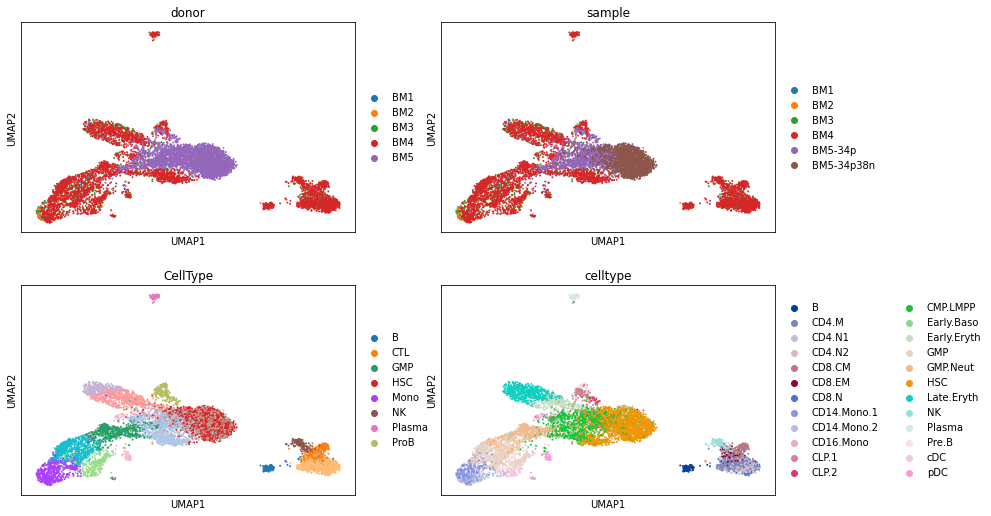

In [3]:
# visualise cells
adata.X = sp.sparse.csr_matrix(adata.X) # need to convert to sparse matrix because it will throw errors downstream
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['donor', 'sample', 'CellType', 'celltype'], ncols=2)

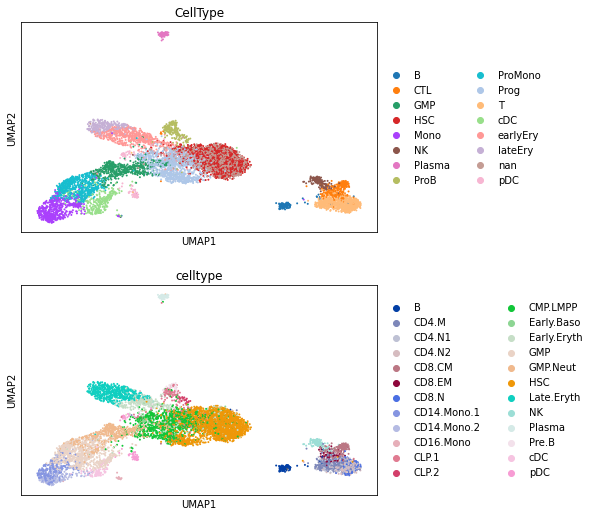

In [6]:
# zoom in on celltypes
sc.pl.umap(adata, color=['CellType', 'celltype'], ncols=1)

Predicted cell types line up very well with the original cell type labels but give more resolution for the T cell clusters in particular. Happy with these labels now.

In [7]:
adata.write('../data/van_Galen/van_Galen_healthy.h5ad')